# Case Study 5: SVM and SGD On Internet Connection Requests

### Team Members:
- Benjamin Goodwin
- Lijju Mathew
- Pradeep Kumar
- Sid Swarupananda

# Business Understanding

We have been requested to use SVM and SGD to attempt to model and predict the class of an internet connection request.  Lets talk about this in more detail, When you type an address such as wikipedia.org into your browser, you are commanding it to open a TCP channel to the server that responds to that URL (or Uniform Resource Locator, which you can read more about on Wikipedia). A URL is like your home address or phone number because it describes how to reach you.

In this situation, your computer, which is making the request, is called the client. The URL you are requesting is the address that belongs to the server.

Once the TCP connection is established, the client sends a HTTP GET request to the server to retrieve the webpage it should display. After the server has sent the response, it closes the TCP connection. If you open the website in your browser again, or if your browser automatically requests something from the server, a new connection is opened which follows the same process described above. GET requests are one kind of HTTP method a client can call. You can learn more about the other common ones (POST, PUT and DELETE) in this article.

(Source: https://www.codecademy.com/articles/http-requests) 

We are concerned with this topic, because although the example above describes a real request, what about the case where the request has malicious intent?  This is the case we are interested in, whether or not we should allow or deny a given request.  Given our large amount of data, we plan to train some models and assess legitmacy of requests. 

In [63]:
############################################
###### Import required Python packages #####
############################################

import os
import pandas as pd
import re
import datetime as dt
import numpy as np
from ipywidgets import interact, interactive, IntSlider, Layout
import ipywidgets as widgets
from IPython.display import display
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import io
import requests
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
warnings.filterwarnings('ignore')

# Data Evaluation/Engineering

In [2]:
import os
os.chdir('/Users/benjamingoodwin/Downloads')

In [3]:
#Bring in the data
df = pd.read_csv('log2.csv') # read in the csv file
df = df.round(5)
df.info()
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # will get summary of continuous or the nominals non-scientific

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000,65532.00000
mean,49391.96934,10577.38581,19282.97276,2671.04993,97123.95009,22385.79691,74738.15318,102.86603,65.83358,41.39953,61.46650
std,15255.71254,18466.02704,21970.68967,9739.16228,5618438.90905,3828138.64979,2463207.71188,5133.00235,302.46176,3218.87129,2223.33227
min,0.00000,0.00000,0.00000,0.00000,60.00000,60.00000,0.00000,1.00000,0.00000,1.00000,0.00000
25%,49183.00000,80.00000,0.00000,0.00000,66.00000,66.00000,0.00000,1.00000,0.00000,1.00000,0.00000
50%,53776.50000,445.00000,8820.50000,53.00000,168.00000,90.00000,79.00000,2.00000,15.00000,1.00000,1.00000
75%,58638.00000,15000.00000,38366.25000,443.00000,752.25000,210.00000,449.00000,6.00000,30.00000,3.00000,2.00000
max,65534.00000,65535.00000,65535.00000,65535.00000,1269359015.00000,948477220.00000,320881795.00000,1036116.00000,10824.00000,747520.00000,327208.00000


# Data Quality

#### In this section, we will verify the data quality, explain missing values, duplicate data, and outliers. We will discuss how we address these issues, and a few variables of interest that may be useful at a later point.

In [4]:
#Check out the data, start to make some decisions on columns and missing data

#Compute percentages of each columns missing data
percent_missing = df.isnull().sum() * 100 / len(df)
#Put percents into df 
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
#Sort it and show the results
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
Source Port,Source Port,0.0
Destination Port,Destination Port,0.0
NAT Source Port,NAT Source Port,0.0
NAT Destination Port,NAT Destination Port,0.0
Action,Action,0.0
Bytes,Bytes,0.0
Bytes Sent,Bytes Sent,0.0
Bytes Received,Bytes Received,0.0
Packets,Packets,0.0
Elapsed Time (sec),Elapsed Time (sec),0.0


#### The plot below examines our outcome variable of interest, 'Action', and based on this plot we can see that there is certainly evidence of a class imbalance.  We will examine this in further detail. We will also take this opportunity to drop "reset-both" as this contains no values.

<AxesSubplot:xlabel='Action', ylabel='Count'>

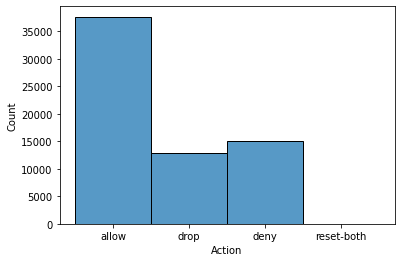

In [5]:
sns.histplot(df['Action'], kde=False)

In [6]:
df.drop(df[df['Action'] == 'reset-both'].index, inplace = True)

<AxesSubplot:xlabel='Action', ylabel='Count'>

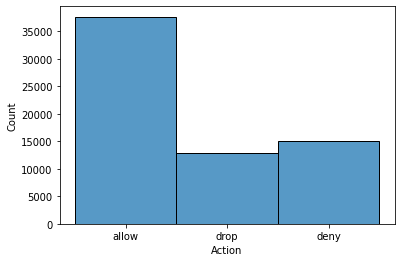

In [7]:
sns.histplot(df['Action'], kde=False)

In [8]:
df['Action'].value_counts(normalize=False)

allow    37640
deny     14987
drop     12851
Name: Action, dtype: int64

In [9]:
target_mod = {
    'allow':'allow',
    'deny':'deny',
    'drop':'deny',
    'reset-both':'deny'
}
df['Action_mod'] = df['Action'].map(target_mod)
del df['Action']
df['Action_mod'] = df['Action_mod'].astype('category')

In [10]:
df['Action_mod'].value_counts(normalize=False)

allow    37640
deny     27838
Name: Action_mod, dtype: int64

<AxesSubplot:xlabel='Action_mod', ylabel='Count'>

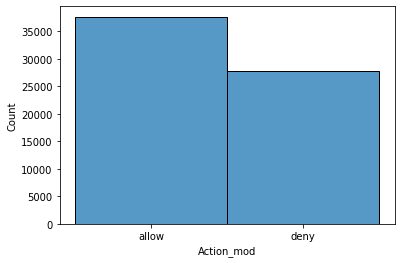

In [11]:
sns.histplot(df['Action_mod'], kde=False)

### Data Evaluation Summary
* The dataset has 65532 rows, 11 features with Action being the target variable.
* There are no missing values.
* The target variable has 4 values allow(57%),deny(22%),drop(19%),reset-both(0.1%). Since the goal of the case study is to either allow or deny the traffic, drop and reset-both are considered as drop.
* We are keeping all varibles as we believe them to be relevant to answering the question of allow/drop
* The dataset is fairly balanced with 57% of rows with allow and 43% with deny.
* Based on these assumptions, we believe we can proceed with SVM and SGD.  At this point there are no further assumptions to express to the audience.
    

# Modeling Preperations

To solve this problem we will implement a support vector machine and use stochastic graident descent, these methods have been deteremined appropriate given the business objective as our stakeholders requested that we implment the filter using these algorithms.  We will use the approaches in tandem with each other, however we will rely on our metrics defined below to determine a "successful" algorithm.  We will also take computation time into account as this could be particularly useful for allowing or denying web traffic, as this takes place rather quickly.

To split up the data into a training and test data set we used an 80% training data and 20% testing data split.  We used a 5 fold cross validation as our metric. We also should specify that we are judging model performance based on an accuracy metric as well as F1 score as this represents a good balance between precision and recall to determine if our approach is useful. We are aiming for at least 80% accuracy and F1 in order to consider an algorithm successful. 

In [18]:
#This section scales the variables to values between 0 and 1 in order to get the data ready for SVM and SGD.
#We only scale variables that aren't already between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
mms = MinMaxScaler()
dfScaled=df
dfScaled[['Source Port','Destination Port','NAT Source Port','NAT Destination Port','Bytes','Bytes Sent','Bytes Received','Packets','Elapsed Time (sec)','pkts_sent','pkts_received']]=mms.fit_transform(dfScaled[['Source Port','Destination Port','NAT Source Port','NAT Destination Port','Bytes','Bytes Sent','Bytes Received','Packets','Elapsed Time (sec)','pkts_sent','pkts_received']])
print(dfScaled)
SVMDat = dfScaled.copy()

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0         0.873165          0.000809         0.832944              0.000809   
1         0.858455          0.051713         0.858442              0.051713   
2         0.104999          0.767849         0.660182              0.767849   
3         0.771401          0.051713         0.771389              0.051713   
4         0.762993          0.006760         0.699596              0.006760   
...            ...               ...              ...                   ...   
65527     0.971877          0.001221         0.201984              0.001221   
65528     0.777673          0.001221         0.205768              0.001221   
65529     0.837291          0.006790         0.000000              0.000000   
65530     0.837275          0.006790         0.000000              0.000000   
65531     0.837230          0.006790         0.000000              0.000000   

              Bytes    Bytes Sent  Bytes Received  

## Training and Test Split

In [20]:
#This is the section where we begin to split up the data
#This is where we create the 80% test, 20%train split
from sklearn.model_selection import train_test_split

#Drop outcome variable from x and keep in y
X = dfScaled.drop('Action_mod', axis=1)
y = dfScaled['Action_mod']

#Direct train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)




## SVM

In [21]:
from sklearn.model_selection import ShuffleSplit

#Want to predict and x and y 
y = y # get the labels we want
X = X # use everything else to predict!
#Use CV objec
#Do 5 iterations
num_cv_iterations = 5
num_instances = len(y)
#Notice set as random state
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=3,test_size  = 0.2)
#Print CV object to ensure everything correct                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=3, test_size=0.2, train_size=None)


In [24]:
for train_indices, test_indices in cv_object.split(X,y): 
   
    X_train = X.iloc[train_indices]

In [30]:
from sklearn import svm
# train object
#Iterate through different train/test splits
svm_clf = svm.SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
iter_num=0    
for train_indices, test_indices in cv_object.split(X,y): 
   
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    # scale attributes by the training set
    scl_obj = StandardScaler()
    scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test)
    

    svm_clf.fit(X_train_scaled, y_train)
            
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

    accSVM = mt.accuracy_score(y_test,y_hat)
    confSVM = mt.confusion_matrix(y_test,y_hat)
    f1SVM = mt.f1_score(y_test, y_hat,pos_label="allow")
    print("====Iteration",iter_num," ====")
    print("accuracy", accSVM)
    print("F1 Score:", f1SVM)
    print("confusion matrix\n",confSVM)
    iter_num+=1

====Iteration 0  ====
accuracy 0.9934331093463653
F1 Score: 0.9942765872487689
confusion matrix
 [[7470   83]
 [   3 5540]]
====Iteration 1  ====
accuracy 0.9926695174098962
F1 Score: 0.9935751572747958
confusion matrix
 [[7423   93]
 [   3 5577]]
====Iteration 2  ====
accuracy 0.9927458766035431
F1 Score: 0.9936203075683298
confusion matrix
 [[7398   93]
 [   2 5603]]
====Iteration 3  ====
accuracy 0.9934331093463653
F1 Score: 0.9942405571926065
confusion matrix
 [[7423   83]
 [   3 5587]]
====Iteration 4  ====
accuracy 0.9924404398289554
F1 Score: 0.9933409564807963
confusion matrix
 [[7384   98]
 [   1 5613]]


## Support Vectors

In [40]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(2606, 11)
(2606,)
[1315 1291]


In [50]:
df_tested_on = SVMDat.iloc[train_indices].copy() # saved from above, the indices chosen for training
print(SVMDat.iloc[train_indices])

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()
df_support.info()
print(train_indices.shape)
df_support['Action_mod'] = y.iloc[svm_clf.support_] 

SVMDat['Action_mod'] = y 
df_support.info()

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
27681     0.996612          0.006790         0.000000              0.000000   
10117     0.787301          0.006760         0.755550              0.006760   
36163     0.961730          0.006790         0.000000              0.000000   
2610      0.867687          0.000809         0.183139              0.000809   
52098     0.893994          0.006790         0.000000              0.000000   
...            ...               ...              ...                   ...   
40505     0.945082          0.006790         0.000000              0.000000   
39512     0.874950          0.006790         0.000000              0.000000   
62304     0.807535          0.006760         0.683192              0.006760   
59237     0.788491          0.006790         0.000000              0.000000   
46037     0.919630          0.006790         0.000000              0.000000   

              Bytes    Bytes Sent  Bytes Received  

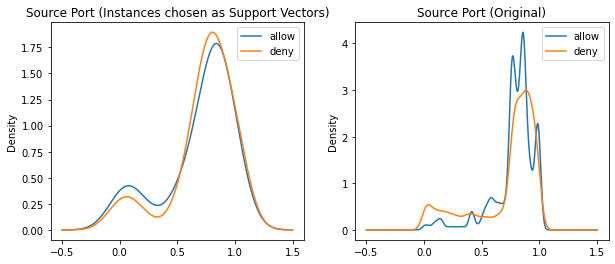

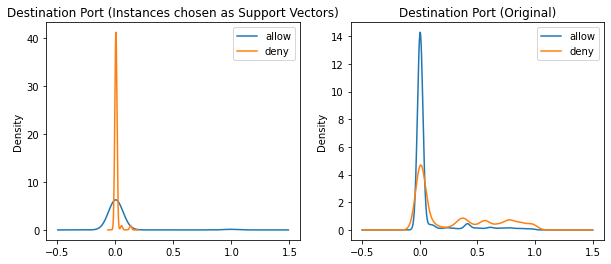

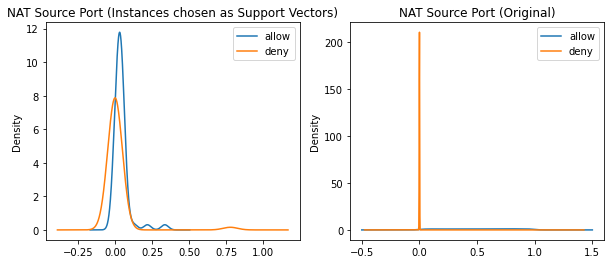

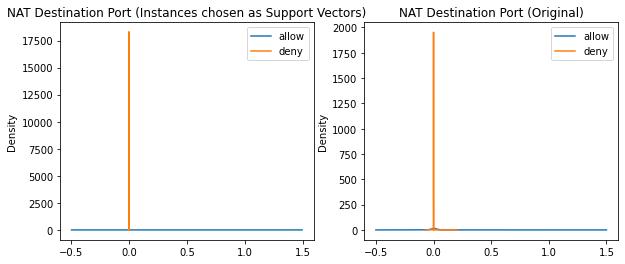

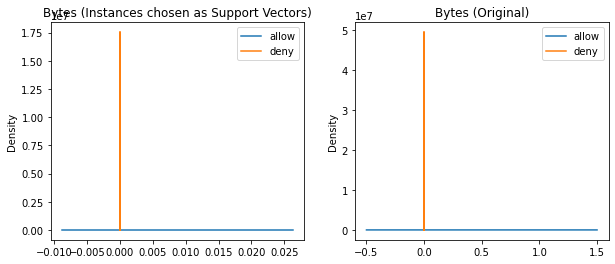

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt

# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Action_mod'])
df_grouped = SVMDat.groupby(['Action_mod'])

# plot KDE of Different variables
vars_to_plot = ['Source Port','Destination Port','NAT Source Port','NAT Destination Port','Bytes']
for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['allow','deny'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['allow','deny'])
    plt.title(v+' (Original)')

### Information on the support vectors

(2606, 11)

The indices of support vectors is 2606 with 11 features.

(1315 1291)
This is the number of support vectors for each class. 'Action_mod' has two classes 'Allow', 'Deny'

Support vectors are the data points that lie closest to the decision surface and are the points that are most difficult to classify.

Based on the results above, we will consider SVM a successful model as it exceeded our metrics for success of accuracy above .8 and an f1 score above .8.  

## SGD

#### In the sections below we will investigate the impact of applying stochastic gradient descent to our models, varying paramters, and observing outcomes.

In this first block we will approach stochastic gradient descent by means of a similar approach to our SVM block with 5-fold CV. 

In [62]:
regularize_const = 0.1
iterations = 5
iter_num=0   
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    
    svm_sgd.fit(scl.fit_transform(X.iloc[train_idx]),y.iloc[train_idx])
    yhat = svm_sgd.predict(scl.transform(X.iloc[test_idx]))
    
    conf = mt.confusion_matrix(y.iloc[test_idx],yhat)
    acc = mt.accuracy_score(y.iloc[test_idx],yhat)
    f1SVM = mt.f1_score(y_test, y_hat,pos_label="allow")
    print("====Iteration",iter_num," ====")
    print("accuracy", accSVM)
    print("F1 Score:", f1SVM)
    print("confusion matrix\n",confSVM)
    iter_num+=1



====Iteration 0  ====
accuracy 0.9924404398289554
F1 Score: 0.9933409564807963
confusion matrix
 [[7384   98]
 [   1 5613]]
====Iteration 1  ====
accuracy 0.9924404398289554
F1 Score: 0.9933409564807963
confusion matrix
 [[7384   98]
 [   1 5613]]
====Iteration 2  ====
accuracy 0.9924404398289554
F1 Score: 0.9933409564807963
confusion matrix
 [[7384   98]
 [   1 5613]]
====Iteration 3  ====
accuracy 0.9924404398289554
F1 Score: 0.9933409564807963
confusion matrix
 [[7384   98]
 [   1 5613]]
====Iteration 4  ====
accuracy 0.9924404398289554
F1 Score: 0.9933409564807963
confusion matrix
 [[7384   98]
 [   1 5613]]
CPU times: user 3.45 s, sys: 521 ms, total: 3.97 s
Wall time: 967 ms


Based on the results above, we exceeded both of our metrics with some very standard model parameters of using hinge loss, and an optimal learning rate.  We will investigate further below

In [66]:
clf_sgd1 = SGDClassifier(loss="hinge", penalty="l2")
clf_sgd1.fit(X_train, y_train)
y_pred_train1 = clf_sgd1.predict(X_train)
print("Confusion Matrix \n",mt.confusion_matrix(y_train, y_pred_train1))
print("\n Classification Report \n",mt.classification_report(y_train, y_pred_train1, digits=6))

Confusion Matrix 
 [[28959  1199]
 [   11 22213]]

 Classification Report 
               precision    recall  f1-score   support

       allow   0.999620  0.960243  0.979536     30158
        deny   0.948787  0.999505  0.973486     22224

    accuracy                       0.976900     52382
   macro avg   0.974204  0.979874  0.976511     52382
weighted avg   0.978053  0.976900  0.976969     52382



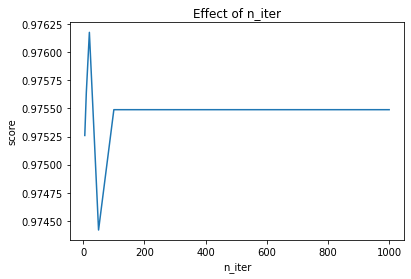

In [67]:
n_iters = [5, 10, 20, 50, 100, 1000]
scores = []
for n_iter in n_iters:
    model = SGDClassifier(loss="hinge", penalty="l2", max_iter=n_iter)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
  
plt.title("Effect of n_iter")
plt.xlabel("n_iter")
plt.ylabel("score")
plt.plot(n_iters, scores)

In the block above, we investiated the effects of increasing the number of n_iterations.  Based on the plot we can see that we have model convergence in n_iterations at around 200 iterations.  This is useful for compute time, we can set a reasonable number of iterations based on this. 

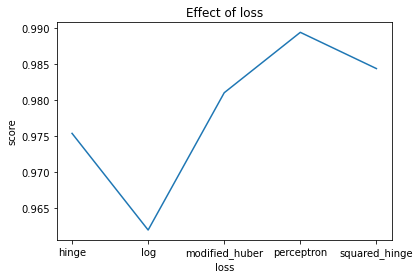

In [68]:
# losses
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    model = SGDClassifier(loss=loss, penalty="l2", max_iter=100)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
  
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 

In the block above we look at the various impacts from changing the loss function.  This, again is informative and useful for modifying model parameters based on values of interest.

Based on the results above, we will consider SGD a successful model as it exceeded our metrics for success of accuracy above .8 and an f1 score above .8.  

# Conclusions

After all of our technical analysis and modeling, we propose to the audience that for sufficiently accurate and precise network traffic allow/deny requests either SVM or SGD may be used.  When moving foward it is important to note that either method solved this problem with flying colors, when moving foward with real life data and/or dealing with this in real-time we would suggest using the algorithm with faster compute time as network traffic decisions need to be decided in milliseconds. 

If SVM or SGD are not the preferred algorithms, we suggest using logistic regression.  This is a classic use case for LR, as this is a binary decision problem.  Logistic regression has the advantage of being more popular, although not necessarily better performing.  LR would simply provide a different approach to this problem.

To wrap everything up, we believe that we have a 2 solid solutions to the problems of network allow/deny requests and those are SVM and SGD.